In [5]:
!pip install -U bnlp_toolkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 42.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 54.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.4 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=f16518fa11c568c46a58fbd986954e37782dfd26881da4864f5810f143cdf403
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji
  Attempting uninstall: emoji
  

In [6]:
!pip install gdown

In [7]:
!gdown 1y6R4r2azEusl4bLyussZcZvo3-wI3dCn

Downloading...
From (original): https://drive.google.com/uc?id=1y6R4r2azEusl4bLyussZcZvo3-wI3dCn
From (redirected): https://drive.google.com/uc?id=1y6R4r2azEusl4bLyussZcZvo3-wI3dCn&confirm=t&uuid=c467b7a6-d17b-4735-a530-54abd193e1f6
To: /kaggle/working/model_bn_300.bin
100%|███████████████████████████████████████| 2.85G/2.85G [00:27<00:00, 102MB/s]


In [8]:
import torch
import torch.nn as nn
import sklearn
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import fasttext
from bnlp import BasicTokenizer
from bnlp import SentencepieceTokenizer
from bnlp import BengaliWord2Vec
from bnlp import NLTKTokenizer
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import precision_recall_fscore_support


In [9]:
df = pd.read_csv("/kaggle/input/hatespeech/train.csv")

# Cleaning


In [10]:
def clean_text(text):
    # Emoji removal pattern covering various emoji ranges
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F700-\U0001F77F"
                               u"\U0001F780-\U0001F7FF"
                               u"\U0001F800-\U0001F8FF"
                               u"\U0001F900-\U0001F9FF"
                               u"\U0001FA00-\U0001FA6F"
                               u"\U0001FA70-\U0001FAFF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    # Remove emojis
    text = emoji_pattern.sub(r'', text)
    # Remove English characters & numbers
    text = re.sub(r'[A-Za-z0-9]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove punctuation
    text = re.sub(r'[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]০১২৩৪৫৬৭৮৯', '', text)
    punctuations = '''`|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''
    # Create a character class to remove specified characters
    regex_pattern = '[' + re.escape(punctuations) + ']'
    text = re.sub(regex_pattern, '', text)


    return text

df['sentence'] = df['sentence'].apply(clean_text)
df = df.drop(columns=['type','target'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 40224 entries, 0 to 40223

Data columns (total 2 columns):

 #   Column    Non-Null Count  Dtype 

---  ------    --------------  ----- 

 0   sentence  40224 non-null  object

 1   target    19324 non-null  object

dtypes: object(2)

memory usage: 628.6+ KB


In [5]:
df.isnull().sum() # Null values mean the corresponding sentence is not hate speech

sentence        0
target      20900
dtype: int64

In [31]:
df.isnull().sum() 


sentence    0
target      0
dtype: int64

# Tokenization

In [11]:
basic_tokenizer = BasicTokenizer()

df['sentence'] = df['sentence'].apply(basic_tokenizer.tokenize)
df

,sentence,hate speech
0,"[ঐ, ইন্দুর, তোই, মরছ, নাই]",1
1,"[গেবনের, শেষে, আইসা, আপনার, মুখোশ, টা, খুলছে, ...",1
2,"[মুরগি, চোরের, পাছায়, ডুকবি, আর, মারবি]",1
3,"[কোটির, চোদা, খাওয়া, শেষে, এখন, কোটির, চোদা, খ...",1
4,"[য়, মীর, জাফরের, মুখে, মুতে, দে]",1
...,...,...
40219,"[গানটা, চালু, করে, ওয়াস, রুমে, গিয়েছিলাম, এসে,...",0
40220,"[হালকার, উপজেলা, ঝাপসা]",0
40221,[],0
40222,"[পুরাই, আগুনের, গুলা]",0


In [12]:
pf = df.copy()
#pf.to_csv('train_processed(target).csv', index=False)

In [13]:
pf['sentence'] = pf['sentence'].apply(lambda x: x if isinstance(x, list) and len(x) > 0 else [])

# Filter out rows where 'tokenized_text' is an empty list
pf = pf[pf['sentence'].map(len) > 0]

# Reset index after filtering
pf.reset_index(drop=True, inplace=True)

# Training & evaluation loops

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [99]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

def trainF(model, num_epochs, lr, train_loader, test_loader, early_stopping, lr_scheduler):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    if early_stopping:
        print('Using Early stopping...')
    else:
        print('No Early stopping...')   
    if lr_scheduler:
        scheduler = ReduceLROnPlateau(optimizer, mode='min',factor=0.2, patience=2, verbose=True)
        print('Using Learning Rate Scheduler...')
    else:
        print('No Learning Rate Scheduler...')         
    # Early stopping parameters
    early_stopping_patience = 15
    early_stopping_counter = 0
    best_val_loss = float('inf')

    # Training and validation loop
    num_epochs = num_epochs  # Increased epochs due to early stopping
    train_losses = []
    valid_losses = []
    print('Starting training...')
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * data.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        running_loss = 0.0

        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * data.size(0)

        val_loss = running_loss / len(test_loader.dataset)
        valid_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        
        if lr_scheduler:
            #print('Triggering scheduler...')
            scheduler.step(val_loss)
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), 'model.pth')  # Save the best model
        else:
            early_stopping_counter += 1
            if early_stopping:
                if early_stopping_counter >= early_stopping_patience:
                    print("Early stopping triggered.")
                    break
            
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()            
# Load the best model back


In [94]:
def evaluate_model(model, dataloader):    
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for vectors, labels in dataloader:
            vectors, labels = vectors.to(device), labels.to(device)
            outputs = model(vectors)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = (np.array(all_predictions) == np.array(all_labels)).mean() * 100

    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted') 
    precision *= 100
    recall *= 100
    f1 *= 100
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    
    return accuracy, precision, recall, f1

# Set data loaders

Load model and make embedding layer

In [95]:
import fasttext
import torch
import torch.nn as nn

# Load the pretrained FastText model
ft_model = fasttext.load_model('model_bn_300.bin')

# Assume you have a list of all unique words in your dataset: `vocab`
vocab = list(set(word for sentence in pf['sentence'] for word in sentence))
vocab.append('<pad>')
vocab.append('<unk>')

# Prepare embedding matrix
embedding_dim = ft_model.get_dimension()
embedding_matrix = torch.zeros((len(vocab), embedding_dim))

word_to_idx = {'<pad>': 0, '<unk>': 1}
for i, word in enumerate(vocab):
    if word in ['<pad>', '<unk>']:
        continue
    embedding_matrix[i] = torch.tensor(ft_model.get_word_vector(word))
    word_to_idx[word] = i

# Create the embedding layer in PyTorch
embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

In [96]:
import numpy as np
from sklearn.model_selection import train_test_split

# Function to convert sentences to indices
def sentence_to_indices(sentence_tokens):
    return [word_to_idx.get(word, word_to_idx['<unk>']) for word in sentence_tokens]

# Convert all sentences to indices
indexed_sentences = [sentence_to_indices(sentence) for sentence in pf['sentence']]

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(indexed_sentences, pf['hate speech'].tolist(), test_size=0.2, random_state=42)


In [97]:
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.rnn as rnn_utils

class CommentDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def collate_fn(batch):
    data, labels = zip(*batch)
    data_padded = rnn_utils.pad_sequence(data, batch_first=True, padding_value=word_to_idx['<pad>'])
    return data_padded, torch.tensor(labels)

# Create DataLoader
train_loader = DataLoader(CommentDataset(X_train, y_train), batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(CommentDataset(X_test, y_test), batch_size=32, shuffle=False, collate_fn=collate_fn)


# Models

LSTM

Using Early stopping...
Using Learning Rate Scheduler...
Starting training...
Epoch 1/30, Train Loss: 0.6936, Validation Loss: 0.6914
Epoch 2/30, Train Loss: 0.6933, Validation Loss: 0.6926
Epoch 3/30, Train Loss: 0.6926, Validation Loss: 0.6925
Epoch 4/30, Train Loss: 0.6926, Validation Loss: 0.6926
Epoch 00004: reducing learning rate of group 0 to 4.0000e-04.
Epoch 5/30, Train Loss: 0.6924, Validation Loss: 0.6925
Epoch 6/30, Train Loss: 0.6924, Validation Loss: 0.6924
Epoch 7/30, Train Loss: 0.6919, Validation Loss: 0.6914
Epoch 00007: reducing learning rate of group 0 to 8.0000e-05.
Epoch 8/30, Train Loss: 0.6881, Validation Loss: 0.6891
Epoch 9/30, Train Loss: 0.6531, Validation Loss: 0.6093
Epoch 10/30, Train Loss: 0.6004, Validation Loss: 0.6021
Epoch 11/30, Train Loss: 0.5849, Validation Loss: 0.5892
Epoch 12/30, Train Loss: 0.5749, Validation Loss: 0.5821
Epoch 13/30, Train Loss: 0.5618, Validation Loss: 0.5641
Epoch 14/30, Train Loss: 0.5373, Validation Loss: 0.5460
Epoch 15/

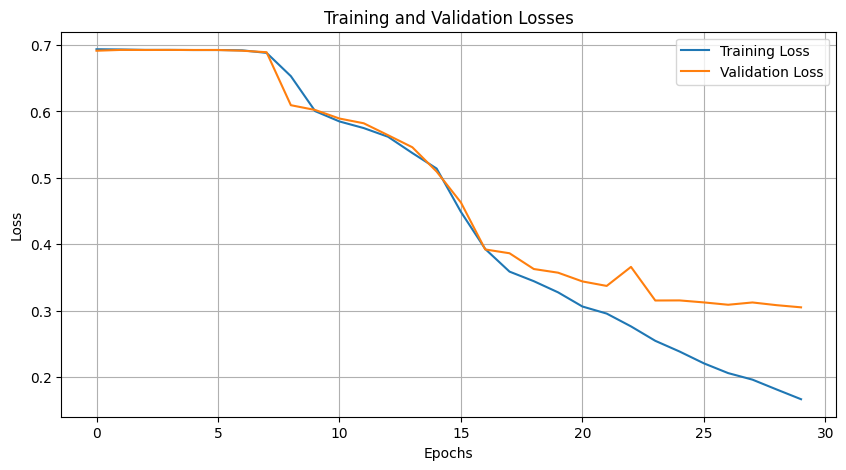

In [100]:
import torch.nn.init as init
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, embedding_layer, hidden_dim, output_dim, num_layers, dropout_rate=0.5):
        super(LSTMModel, self).__init__()
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(embedding_layer.embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Initialize the weights of the LSTM
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                init.orthogonal_(param.data)

        # Initialize the weights of the fully-connected layer
        init.xavier_uniform_(self.fc.weight)
        self.fc.bias.data.fill_(0)

    def forward(self, x):
        embedded = self.embedding(x)  # Pass input through the embedding layer
        output, _ = self.lstm(embedded)
        last_output = output[:, -1, :]
        last_output = self.dropout(last_output)
        return self.fc(last_output)

# Setup the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume embedding_layer is previously defined and loaded with pretrained weights
input_dim = embedding_layer.embedding_dim  # Dimension of the embedding vectors
hidden_dim = 256
output_dim = 2  # Assuming binary classification (0 or 1 for hate speech)
num_layers = 4
dropout_rate = 0.3

# Create an instance of the LSTM model
model_LSTM = LSTMModel(embedding_layer, hidden_dim, output_dim, num_layers, dropout_rate).to(device)
lr = 0.002
num_epochs = 30
lr_schedular = True
early_stopping = True
trainF(model_LSTM, num_epochs, lr, train_loader, test_loader, early_stopping, lr_schedular)


In [101]:
model_LSTM.load_state_dict(torch.load('model.pth'))
lstm_metrics = {}
lstm_metrics['accuracy'], lstm_metrics['precision'], lstm_metrics['recall'], lstm_metrics['f1'] = evaluate_model(model_LSTM, test_loader)

Accuracy: 89.15
Precision: 89.23
Recall: 89.15
F1 Score: 89.15


In [52]:
model_LSTM.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

BI-lstm

Using Early stopping...
Using Learning Rate Scheduler...
Starting training...
Epoch 1/30, Train Loss: 0.5357, Validation Loss: 0.4101
Epoch 2/30, Train Loss: 0.4002, Validation Loss: 0.4298
Epoch 3/30, Train Loss: 0.3490, Validation Loss: 0.3097
Epoch 4/30, Train Loss: 0.2013, Validation Loss: 0.3012
Epoch 5/30, Train Loss: 0.1254, Validation Loss: 0.3839
Epoch 6/30, Train Loss: 0.0796, Validation Loss: 0.3704
Epoch 7/30, Train Loss: 0.0548, Validation Loss: 0.5329
Epoch 00007: reducing learning rate of group 0 to 4.0000e-04.
Epoch 8/30, Train Loss: 0.0328, Validation Loss: 0.5693
Epoch 9/30, Train Loss: 0.0258, Validation Loss: 0.5828
Epoch 10/30, Train Loss: 0.0212, Validation Loss: 0.6883
Epoch 00010: reducing learning rate of group 0 to 8.0000e-05.
Epoch 11/30, Train Loss: 0.0170, Validation Loss: 0.6951
Epoch 12/30, Train Loss: 0.0156, Validation Loss: 0.7315
Epoch 13/30, Train Loss: 0.0146, Validation Loss: 0.7404
Epoch 00013: reducing learning rate of group 0 to 1.6000e-05.
Epoc

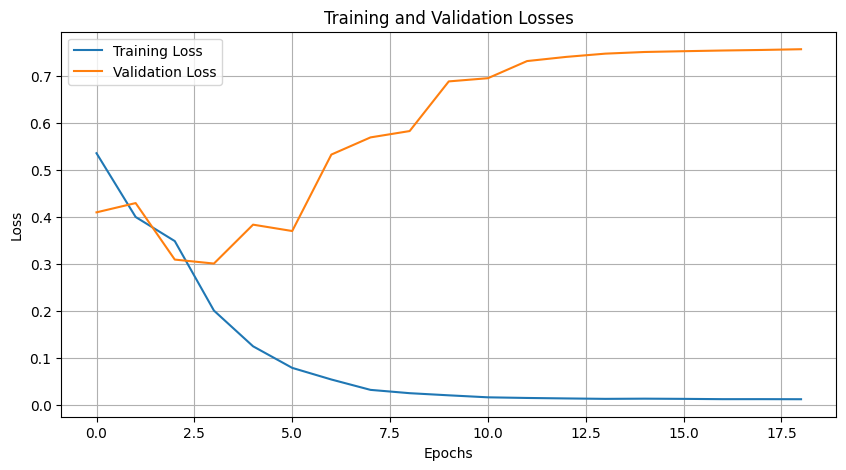

In [102]:
class BiLSTMModel(nn.Module):
    def __init__(self, embedding_layer, hidden_dim, output_dim, num_layers, dropout_rate=0.5):
        super(BiLSTMModel, self).__init__()
        self.embedding = embedding_layer
        self.bilstm = nn.LSTM(embedding_layer.embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Doubled the hidden_dim for bidirectional

        # Initialize the weights of the BiLSTM
        for name, param in self.bilstm.named_parameters():
            if 'weight_ih' in name:
                init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                init.orthogonal_(param.data)

        # Initialize the weights of the fully-connected layer
        init.xavier_uniform_(self.fc.weight)
        self.fc.bias.data.fill_(0)

    def forward(self, x):
        embedded = self.embedding(x)  # Pass input through the embedding layer
        output, _ = self.bilstm(embedded)
        last_output = self.dropout(output[:, -1, :])  # Use the last output for classification
        return self.fc(last_output)

# Setup the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume embedding_layer is previously defined and loaded with pretrained weights
input_dim = embedding_layer.embedding_dim  # Dimension of the embedding vectors
hidden_dim = 128
output_dim = 2  # Assuming binary classification (0 or 1 for hate speech)
num_layers = 4
dropout_rate = 0.3

# Create an instance of the BiLSTM model
model_BiLSTM = BiLSTMModel(embedding_layer, hidden_dim, output_dim, num_layers, dropout_rate).to(device)

lr = 0.002
num_epochs = 30
lr_schedular = True
early_stopping = True

# Train the BiLSTM model
trainF(model_BiLSTM, num_epochs, lr, train_loader, test_loader, early_stopping, lr_schedular)

In [103]:
model_BiLSTM.load_state_dict(torch.load('model.pth'))
bilstm_metrics = {}
bilstm_metrics['accuracy'], bilstm_metrics['precision'], bilstm_metrics['recall'], bilstm_metrics['f1'] = evaluate_model(model_BiLSTM, test_loader)

Accuracy: 88.13
Precision: 88.40
Recall: 88.13
F1 Score: 88.13


GRU

Using Early stopping...
Using Learning Rate Scheduler...
Starting training...
Epoch 1/20, Train Loss: 0.2735, Validation Loss: 0.3542
Epoch 2/20, Train Loss: 0.1209, Validation Loss: 0.3770
Epoch 3/20, Train Loss: 0.0767, Validation Loss: 0.4500
Epoch 4/20, Train Loss: 0.0553, Validation Loss: 0.6070
Epoch 00004: reducing learning rate of group 0 to 4.0000e-04.
Epoch 5/20, Train Loss: 0.0304, Validation Loss: 0.5548
Epoch 6/20, Train Loss: 0.0217, Validation Loss: 0.6290
Epoch 7/20, Train Loss: 0.0174, Validation Loss: 0.6097
Epoch 00007: reducing learning rate of group 0 to 8.0000e-05.
Epoch 8/20, Train Loss: 0.0128, Validation Loss: 0.7032
Epoch 9/20, Train Loss: 0.0108, Validation Loss: 0.7675
Epoch 10/20, Train Loss: 0.0101, Validation Loss: 0.7716
Epoch 00010: reducing learning rate of group 0 to 1.6000e-05.
Epoch 11/20, Train Loss: 0.0088, Validation Loss: 0.7921
Epoch 12/20, Train Loss: 0.0089, Validation Loss: 0.8094
Epoch 13/20, Train Loss: 0.0083, Validation Loss: 0.8190
Epoc

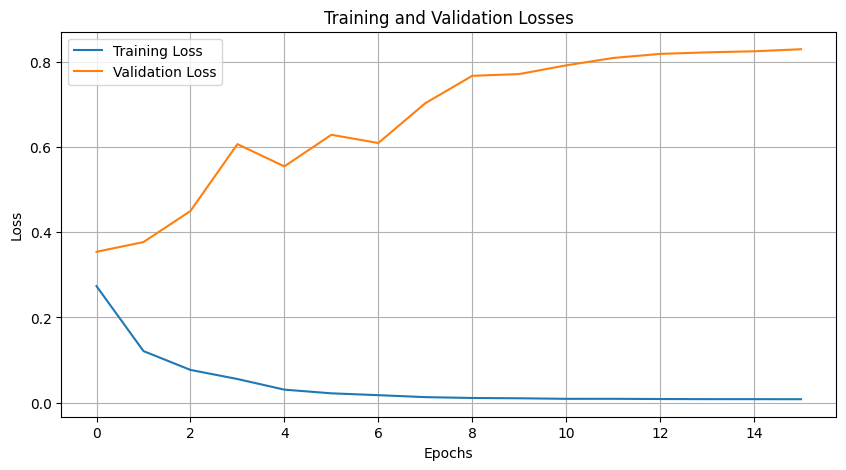

In [104]:
class GRUModel(nn.Module):
    def __init__(self, embedding_layer, hidden_dim, output_dim, num_layers, dropout_rate=0.5):
        super(GRUModel, self).__init__()
        self.embedding = embedding_layer
        self.gru = nn.GRU(embedding_layer.embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Initialize the weights of the GRU
        for name, param in self.gru.named_parameters():
            if 'weight_ih' in name:
                init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                init.orthogonal_(param.data)

        # Initialize the weights of the fully-connected layer
        init.xavier_uniform_(self.fc.weight)
        self.fc.bias.data.fill_(0)

    def forward(self, x):
        embedded = self.embedding(x)  # Pass input through the embedding layer
        output, _ = self.gru(embedded)
        last_output = self.dropout(output[:, -1, :])  # Use the last output for classification
        return self.fc(last_output)

# Setup the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume embedding_layer is previously defined and loaded with pretrained weights
input_dim = embedding_layer.embedding_dim  # Dimension of the embedding vectors
hidden_dim = 256
output_dim = 2  # Assuming binary classification (0 or 1 for hate speech)
num_layers = 4
dropout_rate = 0.3

# Create an instance of the GRU model
model_GRU = GRUModel(embedding_layer, hidden_dim, output_dim, num_layers, dropout_rate).to(device)

lr = 0.002
num_epochs = 20
lr_schedular = True
early_stopping = True

# Train the GRU model
trainF(model_GRU, num_epochs, lr, train_loader, test_loader, early_stopping, lr_schedular)

In [105]:
gru_metrics = {}
gru_metrics['accuracy'], gru_metrics['precision'], gru_metrics['recall'], gru_metrics['f1'] = evaluate_model(model_GRU, test_loader)

Accuracy: 86.50
Precision: 86.50
Recall: 86.50
F1 Score: 86.50


# Comparison

In [106]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots



# Create a list of model names
model_names = ['LSTM', 'BiLSTM', 'GRU']

# Create a list of metric values for each model
accuracy_values = [ lstm_metrics['accuracy'], bilstm_metrics['accuracy'], gru_metrics['accuracy']]
precision_values = [ lstm_metrics['precision'], bilstm_metrics['precision'], gru_metrics['precision']]
recall_values = [ lstm_metrics['recall'], bilstm_metrics['recall'], gru_metrics['recall']]
f1_values = [ lstm_metrics['f1'], bilstm_metrics['f1'], gru_metrics['f1']]

trace1 = go.Bar(x=model_names, y=accuracy_values, name='Accuracy')
trace2 = go.Bar(x=model_names, y=precision_values, name='Precision')
trace3 = go.Bar(x=model_names, y=recall_values, name='Recall')
trace4 = go.Bar(x=model_names, y=f1_values, name='F1-score')

# Create the figure and layout
fig = make_subplots(rows=1, cols=1)
fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col=1)
fig.add_trace(trace3, row=1, col=1)


# Update the layout
fig.update_layout(
    title='Comparison of Evaluation Metrics across Models',
    xaxis_title='Models',
    yaxis_title='Metric Values',
    barmode='group',
    legend=dict(
        x=1.05,
        y=1,
        traceorder='normal',
        bgcolor='rgba(0,0,0,0)',
        bordercolor='Black',
        borderwidth=2
    ),
    xaxis_type='category'
)

# Show the plot
fig.show()

In [156]:
# Assuming 'bwv' is your Bangla word vector model and 'BasicTokenizer' has already been defined
basic_tokenizer = BasicTokenizer()

def preprocess_single_comment(text):
    # Tokenization
    tokens = basic_tokenizer.tokenize(text)

    # Word Embedding
    vectors = sentence_to_vectors(tokens)
    
    # Convert list of vectors to tensor and add an extra dimension for batch size
    if len(vectors) > 0:
        tensor = torch.tensor([vectors], dtype=torch.float32).to(device)
    else:
        # Handling the case where there are no valid words in the comment
        zero_vector = np.zeros(bwv.get_word_vector("গ্রাম").shape)
        tensor = torch.tensor([[zero_vector]], dtype=torch.float32).to(device)
        
    return tensor

def sentence_to_vectors(sentence_tokens):
    vectors = []
    for word in sentence_tokens:
        try:
            vector = bwv.get_word_vector(word)
            vectors.append(vector)
        except KeyError:
            # Handle with a zero vector
            vector = np.zeros(bwv.get_word_vector("গ্রাম").shape)  # Using a generic word to determine the size
            vectors.append(vector)
    return vectors

def predict(model, text):
    model.eval()  # Set model to evaluation mode
    input_tensor = preprocess_single_comment(text)

    with torch.no_grad():
        outputs = model(input_tensor)
        predicted = torch.max(outputs.data, 1)[1].item()  # Get the index of the max log-probability

    return predicted


text = "খানকির পোলারে জুতা দিতে পিডানোর দরকার। ভিডিও ফুটেেজ সব পরিষ্কার হয় গেছে আর সালা নাকি এইটা তদন্ত করবে।"  
prediction = predict(model_LSTM, text)
if prediction==0:
    print(f'Prediction: {prediction}, thus this is not a hate speech')  
else:
    print(f'Prediction: {prediction}, thus this a hate speech')  


Prediction: 1, thus this a hate speech


In [155]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer
import numpy as np
import torch
from torch.nn.functional import softmax

# Prediction function adapted for LIME
def model_predict(texts):
    model_GRU.eval()  # Make sure the model is in evaluation mode
    predictions = []
    for text in texts:
        # Preprocess the text to fit the model's input requirements
        tensor = preprocess_single_comment(text)
        with torch.no_grad():
            output = model_GRU(tensor)
            # Apply softmax to convert logits to probabilities
            output = softmax(output, dim=1)
            predictions.append(output.cpu().numpy()[0])
    return np.array(predictions)

# Initialize LIME text explainer with descriptive class names
class CustomTokenizer:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    
    def __call__(self, doc):
        return self.tokenizer.tokenize(doc)

# Create a custom tokenizer instance using your BasicTokenizer
custom_tokenizer = CustomTokenizer(basic_tokenizer)

# Initialize LIME text explainer with the custom tokenizer
explainer = LimeTextExplainer(class_names=["Non Hate Speech", "Hate Speech"], split_expression=custom_tokenizer)


# Text to explain
text_to_explain = "খানকির পোলারে জুতা দিতে পিডানোর দরকার। ভিডিও ফুটেেজ সব পরিষ্কার হয় গেছে আর সালা নাকি এইটা তদন্ত করবে।ে"

# Generate explanation for the specific instance
exp = explainer.explain_instance(text_to_explain, model_predict, num_features=6, labels=[1])

# Display the explanation for "Hate Speech" class
print('Explanation for class 1 (Hate Speech):')
exp.show_in_notebook(text=True, labels=(1,))


Explanation for class 1 (Hate Speech):
